In [1]:
import notebook_setup
import numpy as np
import torch 
import matplotlib.pyplot as plt

from gpmdm import GPMDM
from dataset_utils.mocap_labels import WALK_TRIALS_TRAIN, WALK_TRIALS_TEST, RUN_TRIALS_TRAIN, RUN_TRIALS_TEST
import dataset_utils.select_joints as select_joints

In [2]:
# Dataset parameters
reduced_columns = WALK_TRIALS_TRAIN[0].get_columns_for_joints(select_joints.WALKING_SIMPLIFIED_JOINTS)
DOFs = len(reduced_columns)
print(f"Number of DOFs: {DOFs}")

# By default, the dataset is 120 fps
# We can downsample it (DOWNSAMPLE of 5 divides the frame rate by 5)
DOWNSAMPLE = 5

walk_train_dfs = [trial.as_dataframe() for trial in WALK_TRIALS_TRAIN]
walk_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::DOWNSAMPLE, :] for df in walk_train_dfs]

run_train_dfs = [trial.as_dataframe() for trial in RUN_TRIALS_TRAIN]
run_train_arrs = [df[reduced_columns].to_numpy().astype(np.float32)[::DOWNSAMPLE, :] for df in run_train_dfs]

WALK_LABEL = 0
RUN_LABEL = 1


Number of DOFs: 35


In [3]:
# Name to save the trained GPDM model
gpdm_save_name = "gpmdm"

# GPDM parameters
d = 4                           # latent space dimension
DOFs = len(reduced_columns)     # number of degrees of freedom
dyn_back_step = 1               # Number of time steps to look back in the dynamics GP

# Initial values for hyperparameters
# These will be optimized during training
y_lambdas_init = np.ones(DOFs)                      # Signal standard deviation for observation GP
y_lengthscales_init = np.ones(d)                    # Lengthscales for observation GP
y_sigma_n_init = 1e-2                               # Noise standard deviation for observation GP
x_lambdas_init = np.ones(d)                         # Signal standard deviation for latent dynamics GP
x_lengthscales_init = np.ones(dyn_back_step*d)      # Lengthscales for latent dynamics GP
x_sigma_n_init = 1e-2                               # Noise standard deviation for latent dynamics GP
x_lin_coeff_init = np.ones(dyn_back_step*d + 1)     # Linear coefficients for latent dynamics GP


# Training parameters
num_optimization_steps = 500
learning_rate = 0.01

In [4]:
gpdm = GPMDM(
        D=DOFs,
        d=d,
        n_classes=2,
        dyn_target='full',
        dyn_back_step=dyn_back_step,
        y_lambdas_init=y_lambdas_init,
        y_lengthscales_init=y_lengthscales_init,
        y_sigma_n_init=y_sigma_n_init,
        x_lambdas_init=x_lambdas_init,
        x_lengthscales_init=x_lengthscales_init,
        x_sigma_n_init=x_sigma_n_init,
        x_lin_coeff_init=x_lin_coeff_init
    )

In [5]:
for train_arr in walk_train_arrs:
    gpdm.add_data(train_arr, WALK_LABEL)
for train_arr in run_train_arrs:
    gpdm.add_data(train_arr, RUN_LABEL)

total_sequences = sum([len(L) for L in gpdm.class_aware_observations_list])
print(f"Total sequences: {total_sequences}")

Total sequences: 19



### Model Training (Adam) ###

GPDM Opt. EPOCH: 0
Running loss: 1.8587e+07
Update time: 1.283015489578247

GPDM Opt. EPOCH: 10
Running loss: 1.3533e+07
Update time: 13.033714771270752

GPDM Opt. EPOCH: 20
Running loss: 1.1102e+07
Update time: 15.663053750991821

GPDM Opt. EPOCH: 30
Running loss: 9.1791e+06
Update time: 18.59735679626465

GPDM Opt. EPOCH: 40
Running loss: 7.6864e+06
Update time: 19.356340408325195

GPDM Opt. EPOCH: 50
Running loss: 6.5293e+06
Update time: 16.87238311767578

GPDM Opt. EPOCH: 60
Running loss: 5.6167e+06
Update time: 13.81477427482605

GPDM Opt. EPOCH: 70
Running loss: 4.8757e+06
Update time: 11.851132869720459

GPDM Opt. EPOCH: 80
Running loss: 4.2592e+06
Update time: 9.879354000091553

GPDM Opt. EPOCH: 90
Running loss: 3.7323e+06
Update time: 9.815656423568726

GPDM Opt. EPOCH: 100
Running loss: 3.2670e+06
Update time: 13.730658531188965

GPDM Opt. EPOCH: 110
Running loss: 2.8461e+06
Update time: 14.782352924346924

GPDM Opt. EPOCH: 120
Running loss: 2.

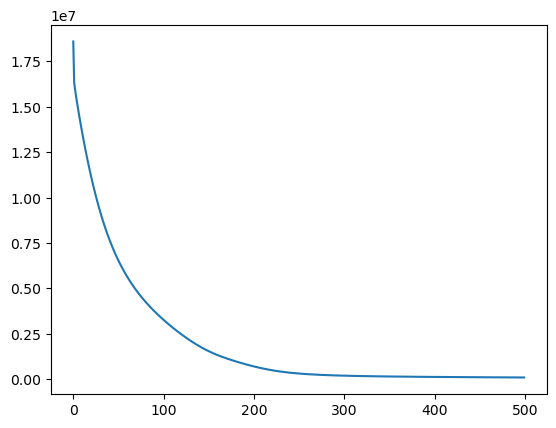

In [ ]:
gpdm.init_X()  
losses = gpdm.train_adam(num_opt_steps=num_optimization_steps, num_print_steps=10, lr=learning_rate)

gpdm.save(f'{gpdm_save_name}_2024_12_04.pth')

plt.plot(losses)

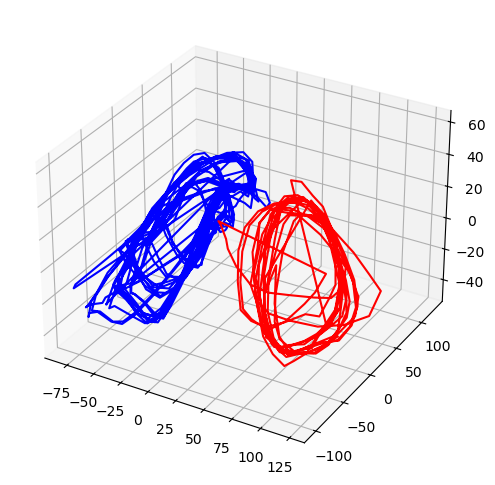

In [7]:
# Plot the latent space
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()

# plot X0 in blue and X1 in red
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

plt.show()

In [8]:
gpdm.set_evaluation_mode()
_, _, _, latent_map_mse = gpdm.get_latent_map_performance()

print(f"Latent map MSE: {latent_map_mse}")

for i in range(gpdm.n_classes):
    _, _, _, latent_map_mse = gpdm.get_latent_map_performance_for_class(i)
    _, _, _, _, dynamics_MSE = gpdm.get_dynamics_map_performance_for_class(i)
    print(f"Class {i} dynamics map MSE: {dynamics_MSE}")
    print(f"Class {i} latent map MSE: {latent_map_mse}")


Latent map MSE: 15.81895777178796
Class 0 dynamics map MSE: 32.17620320855615
Class 0 latent map MSE: 15.977033291192583
Class 1 dynamics map MSE: 24.85668449197861
Class 1 latent map MSE: 15.43064182194617


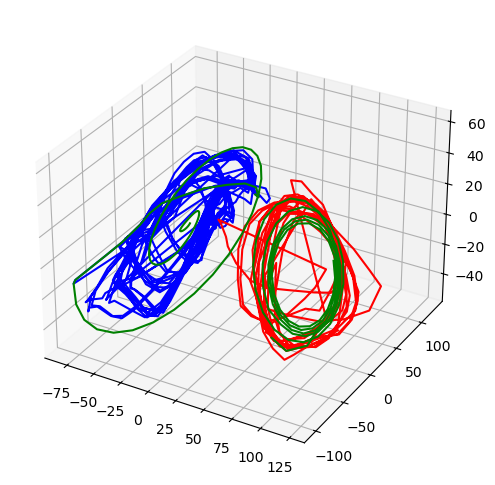

In [9]:
# For each class, pick a random point from the training latent space and generate a sequence

generated = []
for c in range(gpdm.n_classes):
    X0 = gpdm.get_X_for_class(c)
    X0_sample = X0[np.random.randint(X0.shape[0]), :]

    # Generate a sequence
    seq_len = 100
    X_generated = torch.zeros((seq_len, d))
    X_generated[0, :] = X0_sample
    for i in range(1, seq_len):
        X_generated[i, :], _ = gpdm.map_x_dynamics_for_class(X_generated[i-1, :].unsqueeze(0), c)

    generated.append(X_generated.detach().numpy())

# Plot the generated sequence in the latent space in green
fig = plt.figure(figsize=(10, 6))
ax = fig.add_subplot(111, projection='3d')
X0 = gpdm.get_X_for_class(0).detach().numpy()
X1 = gpdm.get_X_for_class(1).detach().numpy()
ax.plot(X0[:, 0], X0[:, 1], X0[:, 2], 'b')
ax.plot(X1[:, 0], X1[:, 1], X1[:, 2], 'r')

for c in range(gpdm.n_classes):
    ax.plot(generated[c][:, 0], generated[c][:, 1], generated[c][:, 2], 'g')

    